# Combine Data (not from prop)

Data has now been filtered for the parcel numbers in the existing dataset. The end goal is to have a dataset with one row for each parcel in which to build the model. **Imputation will occur in a separate notebook!**

However, we can't forget to explore the existing data for trends or insight along the way, as well as engineer features as we see fit.

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

%matplotlib inline

path = '/'.join(os.getcwd().split('/')[:-1])
print path

/Volumes/Dropbox-1/largetransfer/luc/carter


In [134]:
tci = pd.read_csv(path+'/data/model_data/tci_2_0.csv')
ppns = set(tci['ppn'])

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [135]:
tci.shape

(122560, 45)

## Arms length sales

In [136]:
al = pd.read_csv(path+'/data/clean_data/armslength.csv')
al = al.drop_duplicates()

In [137]:
al.shape

(58932, 86)

In [138]:
tem = pd.merge(tci, al[['GRANTOR_IS_MORTGAGEE','PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').sum(), \
               how='left', left_on='ppn', right_index=True)
tem.loc[tem['GRANTOR_IS_MORTGAGEE'].isnull(),'GRANTOR_IS_MORTGAGEE'] = 0

t = tem.loc[tem.vacant>-1,['vacant','GRANTOR_IS_MORTGAGEE']].groupby('GRANTOR_IS_MORTGAGEE').agg([len,sum])
t.vacant['sum']/t.vacant['len']

GRANTOR_IS_MORTGAGEE
0    0.087703
1    0.153005
2    0.000000
dtype: float64

In [139]:
t

vacant      
                         len   sum
GRANTOR_IS_MORTGAGEE              
0                     110966  9732
1                        183    28
2                          1     0

### Number of records for each parcel

In [140]:
tci = pd.merge(tci, al[['PROPERTY_NUMBER','YEAR_OF_SALE']].groupby('PROPERTY_NUMBER').count(), \
               how='left', left_on='ppn', right_index=True)
tci['YEAR_OF_SALE'] = tci['YEAR_OF_SALE'].fillna(0)
tci = tci.rename(columns = {'YEAR_OF_SALE':'num_of_sales'})

In [141]:
t = tci.loc[tci.vacant>-1,['vacant','num_of_sales']].groupby('num_of_sales').agg([len,sum])
t.vacant['sum']/t.vacant['len']

num_of_sales
0    0.074225
1    0.100127
2    0.147637
3    0.199564
4    0.310621
5    0.316667
6    0.407407
7    0.571429
dtype: float64

In [142]:
t

vacant      
                len   sum
num_of_sales             
0             77629  5762
1             24369  2440
2              6665   984
3              1834   366
4               499   155
5               120    38
6                27    11
7                 7     4

### Flags for Deeds

In [143]:
def add_deed_fields(field_names):
    for field_name in field_names:
        deed_ppns = set(al[al.DEED_TYPE==field_name].PROPERTY_NUMBER)                
        def get_deed_field(x):
            if x in deed_ppns:
                return 1
            else:
                return 0

        tci[field_name.lower().replace(' ','_')] = tci['ppn'].apply(get_deed_field)
    return tci

In [144]:
tci = add_deed_fields(['QUIT CLAIM DEED', 'WARRANTY DEED', 'LIMITED WARRANTY', 'SURVIVORSHIP DEED','FIDUCIARY DEED'])

In [145]:
tci.shape

(122560, 51)

In [146]:
tci.loc[tci.vacant>-1,['quit_claim_deed','vacant']].groupby('quit_claim_deed').agg([sum,len])

vacant        
                   sum     len
quit_claim_deed               
0                 8890  107327
1                  870    3823

### Sale Valid {0, 1, 2}

In [147]:
al = al.sort('YEAR_OF_SALE')

In [148]:
al.columns

Index([u'AMOUNT_PAID', u'ASSUMED_LOAN_AMOUNT', u'AUTO_FILE_NUMBER',
       u'BUILDINGS_ON_LAND', u'CAMA_INV_FILE', u'CAMA_SALE_FILE',
       u'CHANGE_TIMESTAMP', u'CONVEYANCE_FEE', u'DEED_TYPE', u'EXEMPTCODE',
       u'EXEMPTCODE_DESCR', u'FEE_CHECK_NUM', u'FEE_PAID_BY', u'GIFT',
       u'GRANTEE1', u'GRANTOR1', u'GRANTOR_IS_MORTGAGEE',
       u'GRANTOR_IS_RELATIVE', u'INSTRUMENT_DATE', u'INSTRUMENT_TYPE',
       u'LAND_CONTRACT', u'LEASED_FEE', u'LEASE_HOLD', u'LIFE_ESTATE',
       u'MINERAL_RIGHTS_RESERVED', u'MONTH_OF_SALE', u'MOTHER',
       u'NUMBER_OF_PROPERTIES_IN_SALE', u'PARTINTER_EST_TRANSFERRED',
       u'PERMISSIVE_FEE', u'PERSONAL_PROPERTY_AMOUNT', u'PROPERTY_NUMBER',
       u'RECEIPT_NUMBER', u'RECORDED_BOOK', u'RECORDED_DATE', u'RECORDED_PAGE',
       u'SALES_AMOUNT', u'SALES_SOURCE', u'SALES_SOURCE_DESCR', u'SALE_VALID',
       u'TRADE', u'mdate', u'TRANSFER_FEE', u'TRANSFER_FROM_PARCEL',
       u'TRANSFER_HISTORY_ID', u'TRANSFER_NUMBER', u'TRANSFER_ORDER',
       u'TRA

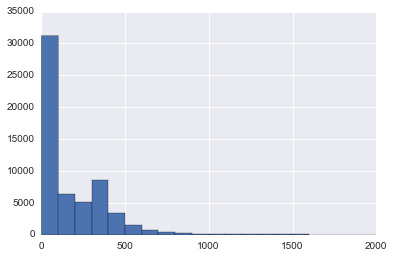

In [149]:
plt.hist(al[al.AMOUNT_PAID<2000].AMOUNT_PAID,20);

In [150]:
al[['SALE_VALID','AMOUNT_PAID','PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').last()

,SALE_VALID,AMOUNT_PAID
PROPERTY_NUMBER,,
001-01-003,0,6400.5
001-01-004,0,1168.5
001-01-008,0,2000.5
001-01-009,2,0.0
001-01-011,2,706.1
001-01-015,0,1170.5
001-01-018,2,0.0
001-01-024,2,660.5
001-01-027,2,942.5


In [151]:
tci = pd.merge(tci, al[['AMOUNT_PAID','PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').last(), \
               how='left', left_on='ppn', right_index=True)
# tci.loc[tci.AMOUNT_PAID.notnull(),'SALE_VALID'] = 1
# tci.loc[tci.SALE_VALID.isnull(),'SALE_VALID'] = 0

In [152]:
tci = pd.merge(tci, al[['SALE_VALID','PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').last(), \
               how='left', left_on='ppn', right_index=True)
tci.loc[tci.SALE_VALID.notnull(),'SALE_VALID'] = 1
tci.loc[tci.SALE_VALID.isnull(),'SALE_VALID'] = 0

In [153]:
t = tci.loc[tci.vacant>-1,['SALE_VALID','vacant']].groupby('SALE_VALID').agg([sum,len])
print t
print t.vacant['sum']/t.vacant['len']

           vacant       
              sum    len
SALE_VALID              
0            5762  77629
1            3998  33521
SALE_VALID
0    0.074225
1    0.119269
dtype: float64


## Transfers

In [154]:
t = pd.read_csv(path+'/data/clean_data/transfers.csv')
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230894 entries, 0 to 230893
Data columns (total 60 columns):
TRANSFER_TO_ID                  230894 non-null int64
WHS_ID                          230894 non-null int64
TRANSFER_HISTORY_ID             230894 non-null int64
TRANSFER_ORDER                  230894 non-null int64
PARCEL_ID                       230894 non-null object
PROPERTY_NUMBER                 230894 non-null object
GRANTEE1                        230891 non-null object
GRANTOR1                        229754 non-null object
mdate                           230894 non-null object
SALES_AMOUNT                    230894 non-null float64
DEED_TYPE                       230890 non-null object
instrument_number               186056 non-null float64
RECORDED_BOOK                   45243 non-null object
RECORDED_PAGE                   45246 non-null object
INSTRUMENT_TYPE                 230894 non-null float64
SALE_VALID                      230894 non-null float64
multiproper

In [155]:
t = t.sort('mdate', ascending=False)

In [156]:
deeds = list(t.groupby('DEED_TYPE').count().sort('mdate',ascending=False).index[0:9])

In [157]:
a = pd.merge(tci, t[t.DEED_TYPE=='Quit Claim Deed'].groupby('PROPERTY_NUMBER').count()[['mdate']], how='left', left_on='ppn',right_index=True)

In [158]:
tci = pd.merge(tci, t.groupby('PROPERTY_NUMBER').count()[['mdate']], how='left', left_on='ppn',right_index=True)
tci = tci.rename(columns={'mdate':'num_of_transfers'})

In [159]:
b = a.loc[a.vacant>-1,['vacant','mdate']].groupby('mdate').agg([sum,len])

In [160]:
b.vacant['sum']*1.0/b.vacant['len']

mdate
1     0.135138
2     0.190476
3     0.264179
4     0.339286
5     0.373134
6     0.233333
7     0.375000
8     0.166667
9     0.000000
10    0.000000
12    0.000000
13    0.000000
dtype: float64

In [161]:
tci = pd.merge(tci, t[['DEED_TYPE', 'PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').first(), \
         how='left', left_on='ppn',right_index=True)

In [162]:
tci.DEED_TYPE = tci.DEED_TYPE.apply(lambda x: x if x in deeds else 'Other')

## County Land Bank

In [163]:
lb = pd.read_csv(path+'/data/clean_data/county_lb.csv')

In [164]:
lb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1660 entries, 0 to 1659
Data columns (total 16 columns):
parcel            1660 non-null object
disp_status       1660 non-null object
p_source          1660 non-null object
acq_dt            1660 non-null object
disp_dt           783 non-null object
assessment        1656 non-null object
demo_status       1032 non-null object
rehab_status      655 non-null object
public_status     1656 non-null object
s_date            1013 non-null object
cclrc_dba_date    787 non-null object
cclrc_dc_date     847 non-null object
ab_proceed_dt     761 non-null object
proceed_date      806 non-null object
cclrc_dcp_date    762 non-null object
out_type          892 non-null object
dtypes: object(16)
memory usage: 220.5+ KB


In [165]:
lb.head()

,parcel,disp_status,p_source,acq_dt,disp_dt,assessment,demo_status,rehab_status,public_status,s_date,cclrc_dba_date,cclrc_dc_date,ab_proceed_dt,proceed_date,cclrc_dcp_date,out_type
0,001-07-034,Acquired,Tax Foreclosure,2014-09-30,NaN,Demolition,Demo - Complete,Changed to Demo,Vacant lot,10/03/2014,02/09/2015,02/12/2015,02/11/2015,02/12/2015,03/11/2015,NaN
1,001-07-045,Disposed,REO,2011-11-29,2012-11-30,Renovate,Changed to Renovate,Rehab - For sale - As Is/Escrow,Disposition,12/06/2011,NaN,06/06/2012,NaN,06/28/2012,NaN,Nonprofit
2,001-08-069,Disposed,Tax Foreclosure,2014-05-19,2015-02-17,Renovate,NaN,Rehab - For sale - As Is/Escrow,Disposition,NaN,NaN,NaN,NaN,NaN,NaN,Private
3,001-08-089,Disposed,Fannie Mae,2011-03-17,2011-08-26,Renovate,NaN,Rehab - NSP2 partner,Disposition,NaN,NaN,NaN,NaN,NaN,NaN,Nonprofit
4,001-08-141,Acquired,Tax Foreclosure,2014-11-18,NaN,Renovate,NaN,Rehab - For sale - As Is/Escrow,For sale,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
lb[['assessment','parcel']].groupby('assessment').count()

,parcel
assessment,
Demolition,962
Pass Through,76
Renovate,532
Vacant lot,86


In [167]:
tci.loc[tci.vacant>-1,['vacant','county_land_bank']].groupby('county_land_bank').agg([sum,len])

Empty DataFrame
Columns: [(vacant, sum), (vacant, len)]
Index: []

In [168]:
lb_ppns = set(lb[lb.disp_dt.isnull()].parcel)

def get_lb(x):
    if x in lb_ppns:
        return 1
    else:
        return 0

tci['county_land_bank'] = tci['ppn'].apply(get_lb)

## Postal Vacancy

In [169]:
pv = pd.read_csv(path+'/data/clean_data/postal_vacancy.csv', parse_dates=3, index_col=[0])

In [170]:
pv.head()

,PARCEL,vindall,date
0,001-02-020,Y,2013-02-01
1,001-02-032,Y,2013-02-01
2,001-03-001,Y,2013-02-01
3,001-04-012,Y,2013-02-01
4,001-04-013,Y,2013-02-01


In [171]:
pv = pv.sort('date',ascending=False)

In [172]:
# tci = pd.merge(tci, al[['SALE_VALID','PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').last(), \
#                how='left', left_on='parcel', right_index=True)

vindall = pv[['PARCEL','vindall']].groupby('PARCEL').first()['vindall']

In [173]:
v_Y = set(vindall[vindall=='Y'].index)

def get_vindall_Y(x):
    if x in v_Y:
        return 1
    else:
        return 0

tci['vindall_Y'] = tci['ppn'].apply(get_vindall_Y)

In [174]:
v_P = set(vindall[vindall=='P'].index)

def get_vindall_P(x):
    if x in v_P:
        return 1
    else:
        return 0

tci['vindall_P'] = tci['ppn'].apply(get_vindall_P)

In [175]:
tci.loc[tci.vacant>-1,['vindall_Y','vacant']].groupby('vindall_Y').agg([sum, len])

vacant        
             sum     len
vindall_Y               
0           5891  100989
1           3869   10161

In [176]:
tci.loc[tci.vacant>-1,['vindall_P','vacant']].groupby('vindall_P').agg([sum, len])

vacant        
             sum     len
vindall_P               
0           9674  110567
1             86     583

In [177]:
tci.to_csv(path+'/data/model_data/tci_2_1.csv', index=False)

In [178]:
tci[tci.median_rent.isnull()].shape

(216, 58)

In [180]:
tci.shape

(122560, 58)